# Analyzer

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

import ipystata
from ipystata.config import config_stata  
config_stata('/Applications/Stata/StataMP.app/Contents/MacOS/stata-mp')  
from IPython.display import Image

In [3]:
PATH = "/Volumes/Extreme SSD/data/analysis"

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))

In [4]:
df.loc[df['price_diff_mw'].isin([np.inf]), 'price_diff_mw'] = None
df.sample(5)

,vendor,w,rating_m,reputation_m,price_usd_m,delta_t_m,neg_rating_m,count_min,neg_count_min,pos_count_min,...,item_count_w,category_count,category_count_w,price_diff_mw,arm_maxw,arm_bgm_maxw,empty_stock_last_week_maxw,m_maxw,rtime_dt_min,has_price_drop
8366,345,26,5.000000,93.923077,47.819240,0.142857,0.002981,301,1.0,313.0,...,2,1,1,1.179317,False,False,False,1,2014-05-22,False
3805,167,17,5.000000,74.000000,45.708177,1.400000,0.030359,20,1.0,32.0,...,3,6,2,1.069644,False,False,False,4,2014-04-12,False
5213,220,17,5.000000,76.165094,63.285804,0.007830,0.064953,7449,513.0,6949.0,...,97,2,2,1.092322,True,True,False,3,2014-06-02,False
21530,916,25,3.578176,95.543478,351.463016,0.011401,0.017477,180447,3094.0,154157.0,...,91,3,2,1.016111,True,True,False,2,2014-06-17,False
3035,137,26,4.917647,69.444444,27.144905,0.082353,0.058477,1696,101.0,1608.0,...,3,6,2,0.992883,False,False,False,2,2014-06-17,False


# Negative Feedbacks

In [5]:
# fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [12,5])
# ax1.grid(True, which="both", ls="-", color='0.9')
# ax2.grid(True, which="both", ls="-", color='0.9')

# # set axes specification
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# colors = {True  : 'red', False : '#1f77b4'}

# vendors = df['vendor'].nunique()
# for vendor in range(vendors):
#     # start enumeration with 1
#     vendor += 1
    
#     # get vendor specific data
#     ven = df.loc[df['vendor'] == vendor]
#     c = ven['arf'].map(colors).max()
#     y = ven['neg_count_min']
#     x = ven['w']
    
#     # plot line per selelr
#     if ven['arf'].max():
#         ax1.plot(x, y, c = c, alpha = .5, label = 'Performed ARF')
#     else:
#         ax2.plot(x, y, c = c, alpha = .5, label = 'Did not perform ARF')

# # make legends for left panel
# handles, labels = ax1.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax1.legend(by_label.values(), by_label.keys(), loc = 'upper left')

# # make legends for right panel 
# handles, labels = ax2.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax2.legend(by_label.values(), by_label.keys(), loc = 'upper left')

# # set axes
# for ax in fig.get_axes():
#     ax.label_outer()
# ax1.set_xlim(0, 50); ax2.set_xlim(0, 50)
# ax1.set_ylim(ymin = 10**0.01, ymax = 10**3.9); ax2.set_ylim(ymin = 10**0.01, ymax = 10**3.9)

# plt.tight_layout()
# plt.show()

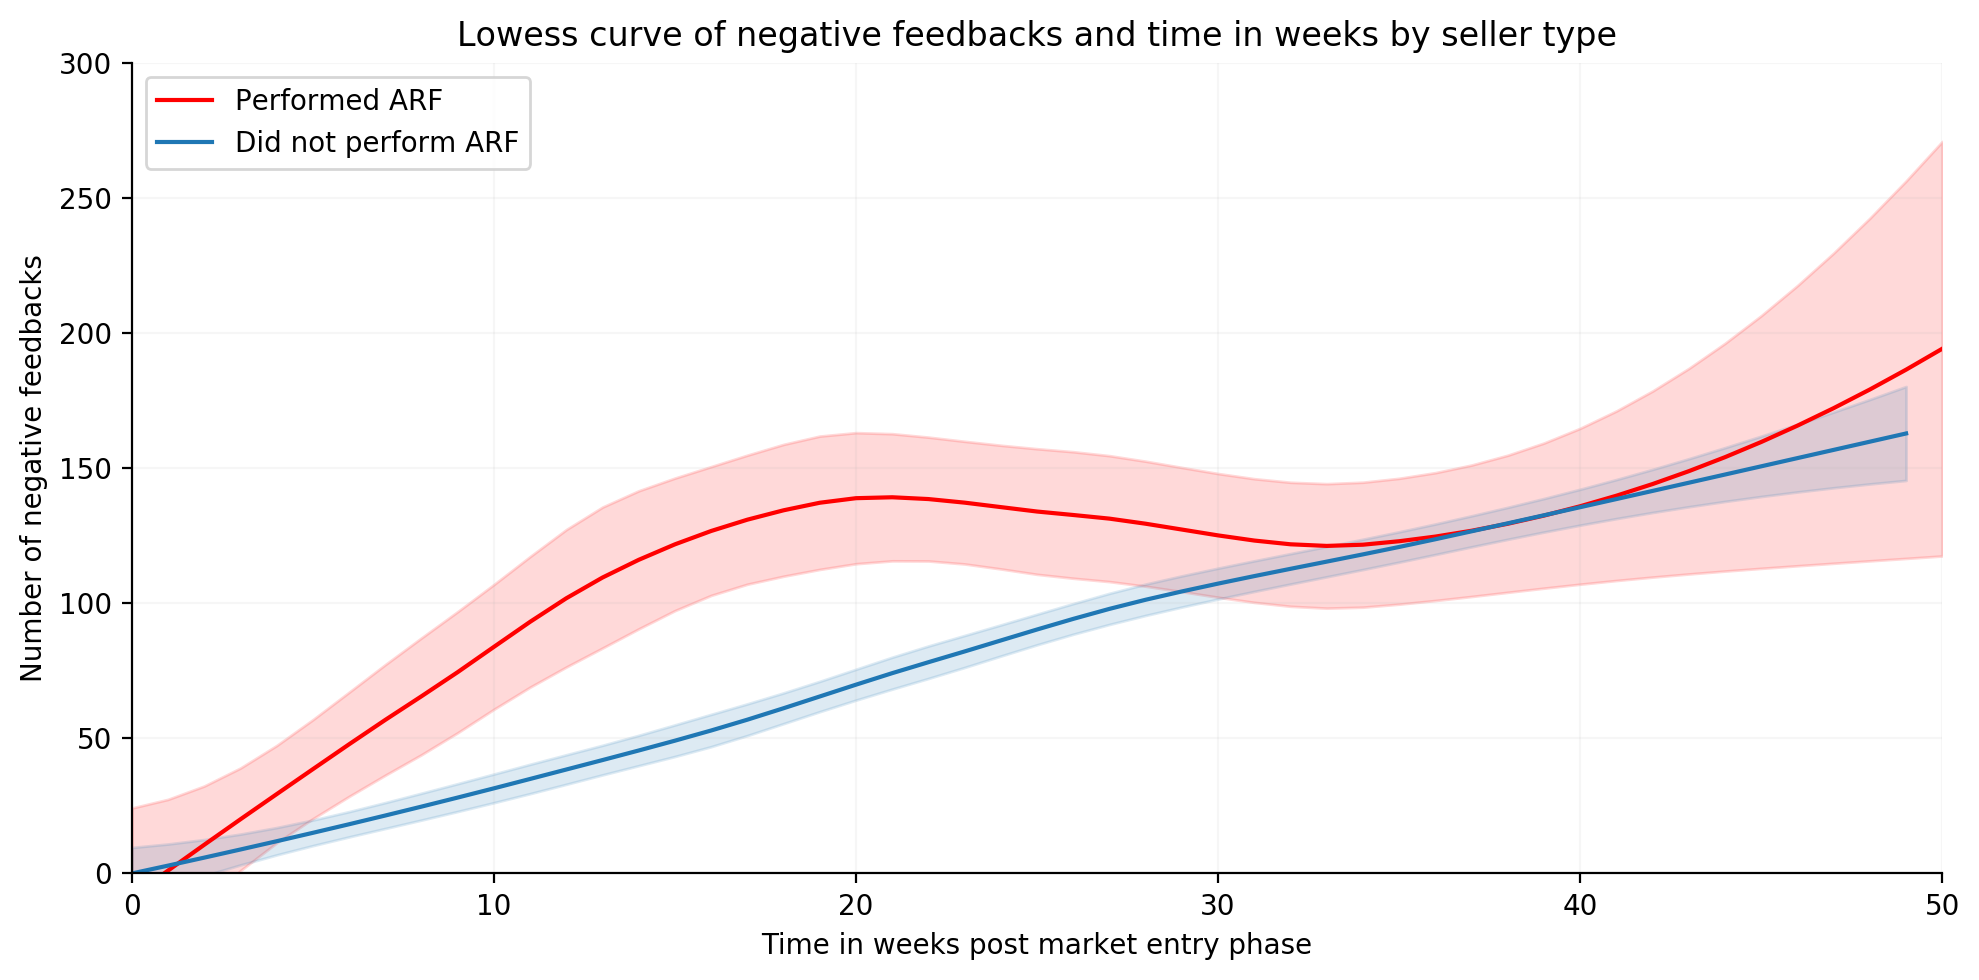

In [6]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    data = df[selection].sort_values('w').copy()
    y = data['neg_count_min'].to_numpy()
    x = data['w'] - 1
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

In [7]:
%%stata -d df

gen ln_neg_count_min = ln(neg_count_min)
gen ln_pos_count_min = ln(pos_count_min)

// group items in terciles
gen items = .
replace items = 0 if item_count <=13
replace items = 1 if item_count > 13 & item_count <= 32
replace items = 2 if item_count > 32

// group categories in terciles 
gen categories = .
replace categories = 0 if category_count <=2
replace categories = 1 if category_count > 2 & category_count <= 4
replace categories = 2 if category_count > 4

mixed ln_neg_count_min i.arf ln_pos_count_min w i.m_maxw i.categories i.items ||w:, covariance(unstructured)


. gen items = .
(24,551 missing values generated)
(8,458 real changes made)
(8,075 real changes made)
(8,018 real changes made)
. gen categories = .
(24,551 missing values generated)
(8,360 real changes made)
(9,141 real changes made)
(7,050 real changes made)
Note: single-variable random-effects specification in w equation; covariance structure set to identity

Performing EM optimization: 

Performing gradient-based optimization: 

Iteration 0:   log likelihood = -41241.328  
Iteration 1:   log likelihood = -41241.328  

Computing standard errors:

Mixed-effects ML regression                     Number of obs     =     24,551
Group variable: w                               Number of groups  =         51

                                                Obs per group:
                                                              min =          1
                                                              avg =      481.4
                                                              m

# ARM

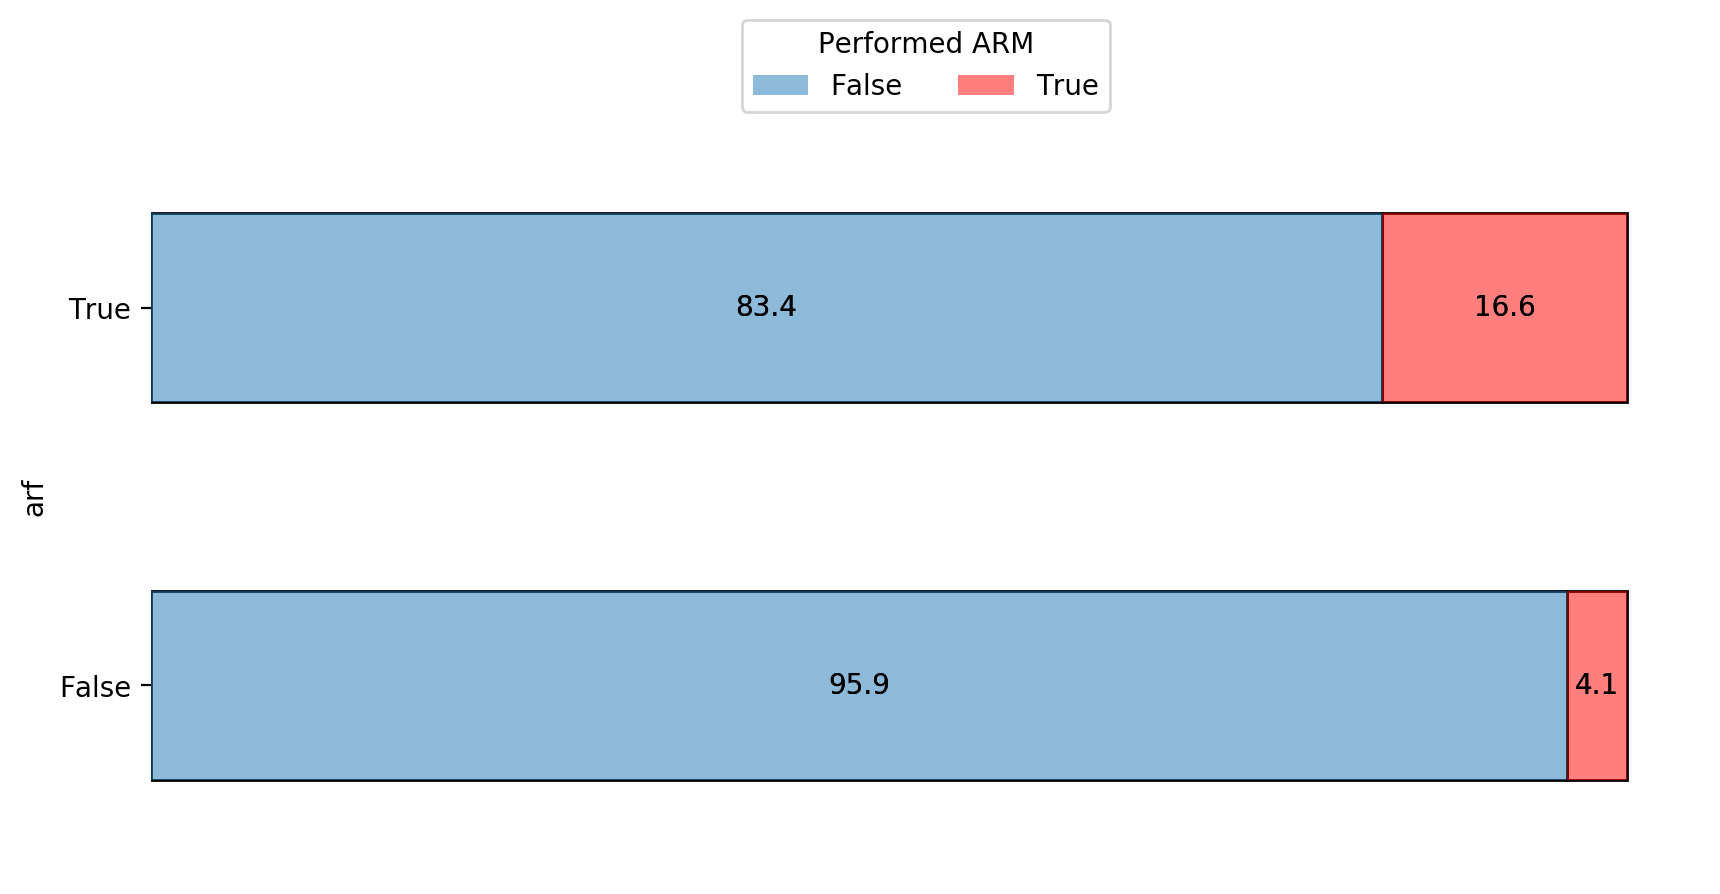

In [12]:
ct = pd.crosstab(df['arf'], df['arm_maxw'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [9]:
%%stata -d df

gen ln_neg_count_min = ln(neg_count_min)
gen ln_pos_count_min = ln(pos_count_min)

// group items in terciles
gen items = .
replace items = 0 if item_count <=13
replace items = 1 if item_count > 13 & item_count <= 32
replace items = 2 if item_count > 32

// group categories in terciles 
gen categories = .
replace categories = 0 if category_count <=2
replace categories = 1 if category_count > 2 & category_count <= 4
replace categories = 2 if category_count > 4

recode m_maxw (12 = 11)

melogit arm_maxw c.ln_neg_count_min##c.arf ln_pos_count_min has_price_drop c.w##c.w i.m_maxw i.items i.categories|| vendor: arf


. gen items = .
(24,551 missing values generated)
(8,458 real changes made)
(8,075 real changes made)
(8,018 real changes made)
. gen categories = .
(24,551 missing values generated)
(8,360 real changes made)
(9,141 real changes made)
(7,050 real changes made)
(m_maxw: 28 changes made)

Fitting fixed-effects model:

Iteration 0:   log likelihood = -4366.5468  
Iteration 1:   log likelihood = -2651.1969  
Iteration 2:   log likelihood = -2559.3588  
Iteration 3:   log likelihood = -2547.6657  
Iteration 4:   log likelihood = -2546.4998  
Iteration 5:   log likelihood = -2546.4747  
Iteration 6:   log likelihood = -2546.4746  

Refining starting values:

Grid node 0:   log likelihood = -2253.2795

Fitting full model:

Iteration 0:   log likelihood = -2253.2795  
Iteration 1:   log likelihood = -2209.6331  
Iteration 2:   log likelihood = -2145.4525  
Iteration 3:   log likelihood = -2142.4307  
Iteration 4:   log likelihood =  -2141.069  
Iteration 5:   log likelihood = -2139.7989  
Ite

# Selling Price Adjustment

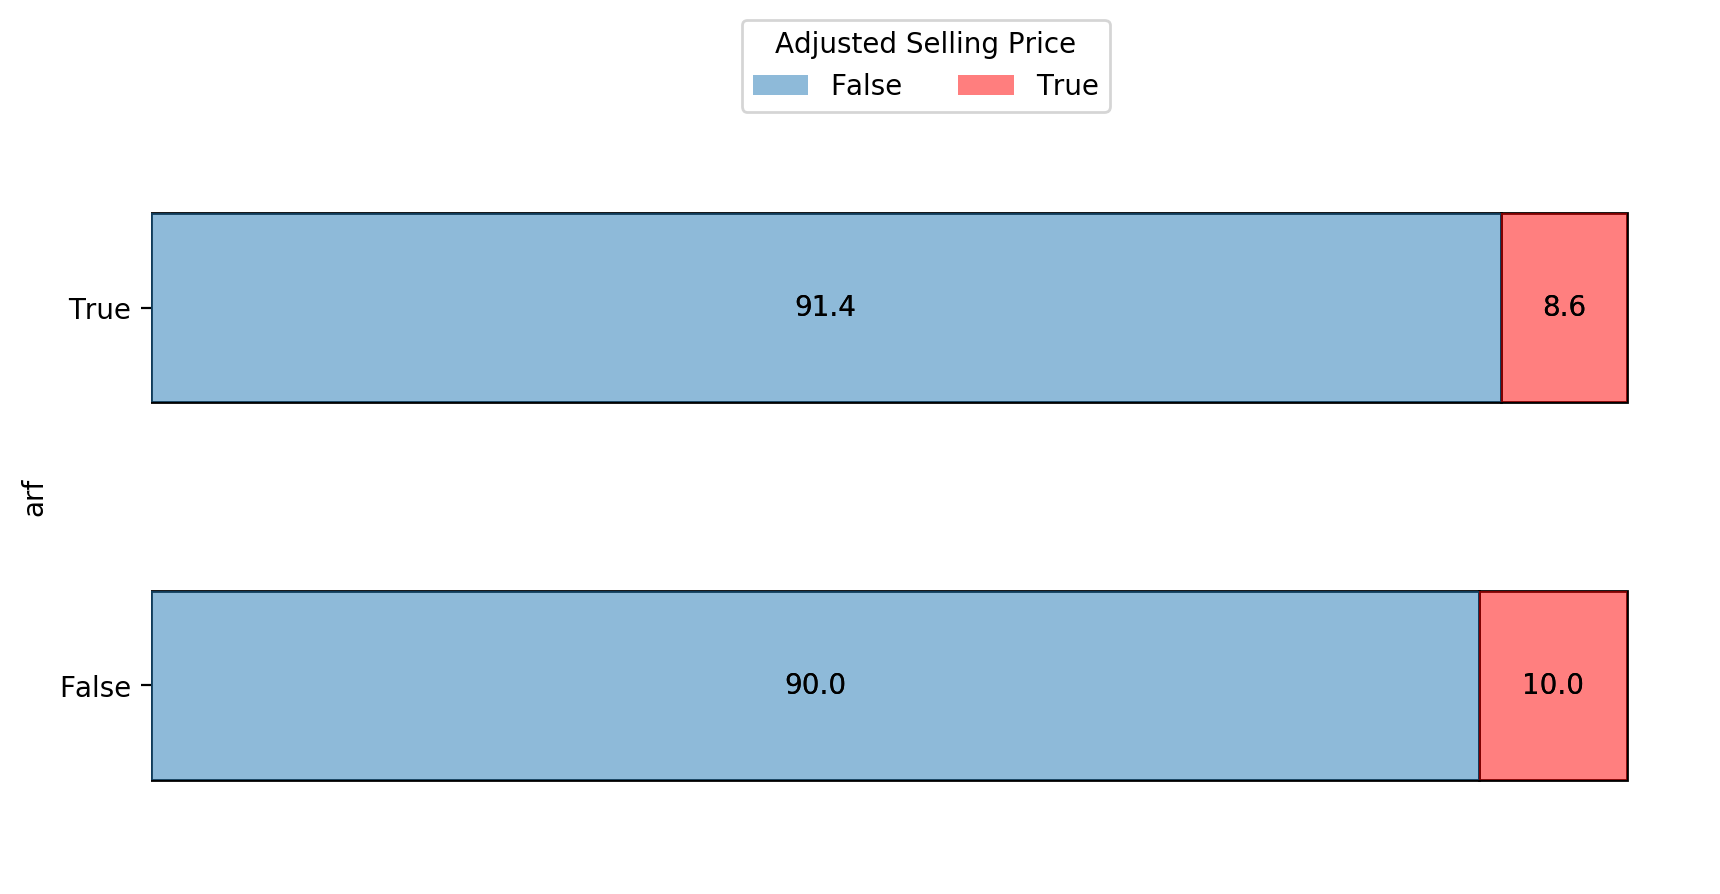

In [10]:
ct = pd.crosstab(df['arf'], df['has_price_drop'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5)
ax.invert_yaxis() 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol = 2, title = 'Adjusted Selling Price')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')
        
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.xticks([])
plt.show()

In [11]:
%%stata -d df

gen ln_neg_count_min = ln(neg_count_min)
gen ln_pos_count_min = ln(pos_count_min)

// group items in terciles
gen items = .
replace items = 0 if item_count <=13
replace items = 1 if item_count > 13 & item_count <= 32
replace items = 2 if item_count > 32

// group categories in terciles 
gen categories = .
replace categories = 0 if category_count <=2
replace categories = 1 if category_count > 2 & category_count <= 4
replace categories = 2 if category_count > 4

recode m_maxw (12 = 11)

melogit has_price_drop c.ln_neg_count_min##c.arf ln_pos_count_min arm_maxw c.w##c.w i.m_maxw i.items i.categories|| vendor: arf


. gen items = .
(24,551 missing values generated)
(8,458 real changes made)
(8,075 real changes made)
(8,018 real changes made)
. gen categories = .
(24,551 missing values generated)
(8,360 real changes made)
(9,141 real changes made)
(7,050 real changes made)
(m_maxw: 28 changes made)

Fitting fixed-effects model:

Iteration 0:   log likelihood = -7876.2735  
Iteration 1:   log likelihood = -7686.0214  
Iteration 2:   log likelihood = -7681.5238  
Iteration 3:   log likelihood =  -7681.253  
Iteration 4:   log likelihood = -7681.2518  
Iteration 5:   log likelihood = -7681.2518  

Refining starting values:

Grid node 0:   log likelihood = -7867.5282

Fitting full model:

Iteration 0:   log likelihood = -7867.5282  (not concave)
Iteration 1:   log likelihood = -7847.2827  (not concave)
Iteration 2:   log likelihood = -7827.1416  (not concave)
Iteration 3:   log likelihood = -7687.5206  
Iteration 4:   log likelihood = -7678.5773  
Iteration 5:   log likelihood = -7678.1318  
Iteration